"We certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that we did not receive any external help, coaching or contributions during the production of this work

#Libraries

In [ ]:
import numpy as np
import gym
from gym import spaces
import copy
from copy import copy
import matplotlib.pyplot as plt
import gym
from gym import spaces
import copy
from copy import copy
import matplotlib.pyplot as plt
from google.colab import widgets
import time

In [ ]:
import os
import torch
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#req files

In [ ]:
!git clone https://github.com/openai/multiagent-particle-envs.git

Cloning into 'multiagent-particle-envs'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 242 (delta 0), reused 3 (delta 0), pack-reused 237
Receiving objects: 100% (242/242), 107.24 KiB | 17.87 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [ ]:
%pwd

'/content'

In [ ]:
%cd /content/multiagent-particle-envs/

/content/multiagent-particle-envs


In [ ]:
!pip install -e .

Obtaining file:///content/multiagent-particle-envs
     |████████████████████████████████| 772 kB 16.7 MB/s 
  Created wheel for numpy-stl: filename=numpy_stl-2.16.3-cp37-cp37m-linux_x86_64.whl size=137060 sha256=70d6aa51e0ea74a6d905eab313103a7638b2b7810fa76adeb3796342c2983092
  Stored in directory: /root/.cache/pip/wheels/06/f4/db/7fac39962a6ba79b7e740892042332083924bff552d4bef41e
Successfully built numpy-stl
  Running setup.py develop for multiagent


In [ ]:
!pip install torch==1.4.0
!pip uninstall gym --y
!pip install gym==0.10.5

     |████████████████████████████████| 753.4 MB 6.5 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.4.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.4.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.4.0 which is incompatible.


Found existing installation: gym 0.17.3
Uninstalling gym-0.17.3:
  Successfully uninstalled gym-0.17.3
     |████████████████████████████████| 1.5 MB 27.8 MB/s 
  Created wheel for gym: filename=gym-0.10.5-py3-none-any.whl size=1581307 sha256=7cdea559b5d9cb2c6185b46b32b5beaf5ba497b85ed6637784fa93c712a97c0d
  Stored in directory: /root/.cache/pip/wheels/7a/2c/df/a05b548a40fae16ca400ecbeda0067e1a296499c1fbd7e0c9a
Successfully built gym


In [ ]:
import torch
torch.__version__

'1.11.0+cu113'

# Basic Multiagent Grid world

In [ ]:
class MAGridWorld(gym.Env):
    
    metadata = { 'render.modes' : ['human', 'rgb_array'] }
        
    def __init__(self, size, n_agents):
        self.size = size
        self._grid_size = (self.size, self.size)
        self.world = np.zeros((self._grid_size))
        self._timestep = None
        self._max_timestep = int(self.size*4)
        self.n_agents = n_agents
        self.dist = int((self.size-1)/(n_agents-1))
        self._step_cost = -0.1
        self.observation_space = spaces.Box(low=0, high=self.size, shape=(self.size, self.size))
        self.action_space = spaces.Discrete(5)

    def reset(self):
        self.agent_pos = []
        self.goal_pos = []
        self._timestep = 0
        self.done = [False for i in range(self.n_agents)]
        for i in range(self.n_agents):
            self.agent_pos.append([self.size-1, i*self.dist])
            self.goal_pos.append([0, i*self.dist])
        self.goal_pos.reverse()
        observation = self.agent_pos
        return observation


    def _compute_distance(self, x, y):
        dist = np.abs(x[0]-y[0]) + np.abs(x[1]-y[1])
        return dist


    def _is_inside_grid(self, pos):
        return (0 <= pos[0] < self._grid_size[0]) and (0 <= pos[1] < self._grid_size[1])


    def _is_collision(self, new_pos, agent):
        for i in range(self.n_agents):
            if i == agent:
                continue
            elif new_pos == self.agent_pos[i]:
                return True
            elif new_pos == self.goal_pos[i]:
                return True

    def step(self, actions):

        self._timestep += 1
        old_pos = self.agent_pos.copy()
        rewards = [0 for _ in range(self.n_agents)]

        for i in range(self.n_agents):
            self.update_agent_pos(i, actions[i])
            old_dist = self._compute_distance(old_pos[i], self.goal_pos[i])
            new_dist = self._compute_distance(self.agent_pos[i], self.goal_pos[i])
            
            if new_dist < old_dist:
                rewards[i] = 1 #-1 worked
            elif new_dist > old_dist:
                rewards[i] = -3 #-2 worked

            elif (new_dist == old_dist) and not self.done[i]:
                rewards[i] = -5 #-2 worked
            
            if (self.agent_pos[i] == self.goal_pos[i]):
                self.done[i] = True
                rewards[i] = 100
            else:
                self.done[i] = False

        if self._timestep >= self._max_timestep:
            self.done = [True for i in range(self.n_agents)]
            
        observation = self.agent_pos
        info = {}
        return observation, rewards, self.done, info #all(done)



    def update_agent_pos(self, agent, action):
        next_pos = copy(self.agent_pos[agent])
        if action == 0: # Down
            next_pos[0] += 1
        elif action == 1: # Up
            next_pos[0] -= 1
        elif action == 2: # Right
            next_pos[1] += 1
        elif action == 3: # Left
            next_pos[1] -= 1
        elif action == 4: # No move
            pass
        else:
            raise Exception('Action is not valid')
            
        if self._is_inside_grid(next_pos) and not self._is_collision(next_pos, agent):
            self.agent_pos[agent] = next_pos
        else:
            pass
        

    def render(self):
        state = np.copy(self.world)
        for i in range(self.n_agents):
            state[tuple(self.agent_pos[i])] = 1 - (0.1 * i)
            state[tuple(self.goal_pos[i])] = 1 - (0.1 * i)
        return plt.imshow(state)

In [ ]:
class RandomAgent:
    
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def step(self, observation):
        return np.random.choice(self.action_space.n)

#1. Q-Learning on Multiagent

In [ ]:
#Q-learning

def q_learning(evaluation = False):
  env = MAGridWorld(4, 2)
  agent = RandomAgent(env)#creating a random agent to explore the given environments 
  obs = env.reset()#resets the environment to its initial configuration
  
  #Intialize parameters
  learning_rate = 0.15 #alpha
  discount_factor = 0.99 #how much weightage to put on future rewards
  det_epsilon = 0.99 # For all states in deterministic environment p(s', r/s, a) = {0, 1}: Either action taken or No action taken


  #Intial state
  current_state = [0, 0] #s1
  action_val = [0,1,2,3]

  #Q table representing 16 rows: one for each state (i.e., 0,1,2,...15) -> (i.e., s1, s2, s3,....s16) and 4 columns: one for each action (i.e., 0,1,2,3) -> (down,up,right,left)
  # (0-15, 0-3) remember the dimension is one less
  q_tables = [np.zeros((16,4)), np.zeros((16,4))] 


  #mapping next_state co-ordinates to q_table co-ordinates
  states = {(0,0): 0, (0,1): 1, (0,2): 2, (0,3): 3,
                (1,0): 4, (1,1): 5, (1,2): 6, (1,3): 7,
                (2,0): 8, (2,1): 9, (2,2): 10, (2,3): 11,
                (3,0): 12, (3,1): 13, (3,2): 14, (3,3): 15} #16 states

  #Empty lists to store values
 
  epsilon_values = []
  
  total_episodes = 10
  epsilon = 1 #multiply by 0.995 for each episode(#after 20 iterations# or terminal state reached)
  decay_factor = (0.01/1)**(1/total_episodes)
  rewards_val = []
  if evaluation == False:
    for episode in range(1, total_episodes+1):
      
      obs = env.reset()
      current_states = [0, 0]
      total_rewards = [0, 0]
      timestep = 0

      while timestep < 10: #(i.e., considering untill the terminal is reached or 20 timesteps completed)
      
        actions = []
        next_states = []
        for agent in range(2):

          #e - greedy algorithm
          rand_num = np.random.random()
          if epsilon > rand_num:
            action = np.random.choice(action_val)
          else:
            action = np.argmax(q_tables[agent][current_states[agent]]) #action in current state s with max_q value
          
          actions.append(action)

        #Taking the action
        next_state_poss, rewards, done, _ = env.step(actions)

        # print("Rewards: ", rewards)
        for pos in next_state_poss:
          next_states.append(states[tuple(pos)])


        #Choosing action with max Q value
        for agent in range(2):

          max_q_action = np.argmax(q_tables[agent][next_states[agent]])

          #Update function
          # print(actions[agent])
          q_tables[agent][current_states[agent]][actions[agent]] = q_tables[agent][current_states[agent]][actions[agent]] + learning_rate*(rewards[agent] + discount_factor*q_tables[agent][next_states[agent]][max_q_action] - q_tables[agent][current_states[agent]][actions[agent]])

          total_rewards[agent] += rewards[agent]

        current_states[0] = next_states[0] #next_state is assigned to current_state
        current_states[1] = next_states[1]
        
        if done[0] and done[1]:
          done[0] = False
          done[1] = False
          break     

      rewards_val.append(total_rewards)
      epsilon_values.append(epsilon) #Append epsilon values in every episode
      

      if epsilon > 0.01: #keeping epsilon in [0.01 - 1] range as if it falls below 0.01 it will exploit more: choosing best actions. We want our agent to explore a bit: choosing random actions
          epsilon = epsilon*decay_factor
      else:
          epsilon = 0.01


      if (episode % 1) == 0:
        print("Episode: {}, epsilon: {}, rewards: {}".format(episode, epsilon, rewards))
        

    #Plotting the results
    #x, y co-ordinates
    x = [episode for episode in range(1, total_episodes+1)]
    ye = epsilon_values
    yr1 = [rewards_val[episode][0] for episode in range(total_episodes)]
    yr2 = [rewards_val[episode][1] for episode in range(total_episodes)]
    # yr2 = total_rewards[1]

    #Plots showing episodes vs epsilon, episodes vs rewards
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
    #episodes vs epsilon
    ax1.plot(x, ye)
    ax1.set_title("Epsilon decay")

    #episodes vs rewards
    ax2.plot(x,yr1)
    ax2.set_title("Agent1: Rewards per episode")

    #episodes vs rewards
    ax3.plot(x,yr2)
    ax3.set_title("Agent2: Rewards per episode")

  else:
    eval_rewards_val = []

    for i in range(10):
      obs = env.reset()
      current_states = [0, 0]
      total_rewards = [0, 0]
      timestep = 0
      agent1_states = [13]
      agent2_states = [16]

      while timestep < 10: #(i.e., considering untill the terminal is reached or 20 timesteps completed)
      
        actions = []
        next_states = []
        
        for agent in range(2):
          action = np.argmax(q_tables[agent][current_states[agent]]) #action in current state s with max_q value
          actions.append(action)

        #Taking the action
        next_state_poss, rewards, done, _ = env.step(actions)

        # print("Rewards: ", rewards)
        for pos in next_state_poss:
          next_states.append(states[tuple(pos)])

        #Choosing action with max Q value
        for agent in range(2):

          max_q_action = np.argmax(q_tables[agent][next_states[agent]])

          #Update function
          q_tables[agent][current_states[agent]][actions[agent]] = q_tables[agent][current_states[agent]][actions[agent]] + learning_rate*(rewards[agent] + discount_factor*q_tables[agent][next_states[agent]][max_q_action] - q_tables[agent][current_states[agent]][actions[agent]])

          total_rewards[agent] += rewards[agent]
        
        agent1_states.append(next_states[0] + 1)
        agent2_states.append(next_states[1] + 1)
        current_states[0] = next_states[0] #next_state is assigned to current_state
        current_states[1] = next_states[1]
        
        if done[0] and done[1]:
          done[0] = False
          done[1] = False
          break     

      eval_rewards_val.append(total_rewards)
      env.render()
      
      # print("Evaluation rewards: ", eval_rewards_val)
      print("Agent 1 route: ", agent1_states)
      print("Agent 2 route: ", agent2_states) 


Episode: 1, epsilon: 0.6309573444801932, rewards: [1, -3]
Episode: 2, epsilon: 0.39810717055349726, rewards: [1, 1]
Episode: 3, epsilon: 0.251188643150958, rewards: [100, 1]
Episode: 4, epsilon: 0.15848931924611134, rewards: [100, 100]
Episode: 5, epsilon: 0.09999999999999999, rewards: [100, 100]
Episode: 6, epsilon: 0.06309573444801932, rewards: [100, -5]
Episode: 7, epsilon: 0.03981071705534972, rewards: [100, 100]
Episode: 8, epsilon: 0.025118864315095798, rewards: [100, 100]
Episode: 9, epsilon: 0.015848931924611134, rewards: [100, 100]
Episode: 10, epsilon: 0.01, rewards: [100, 100]


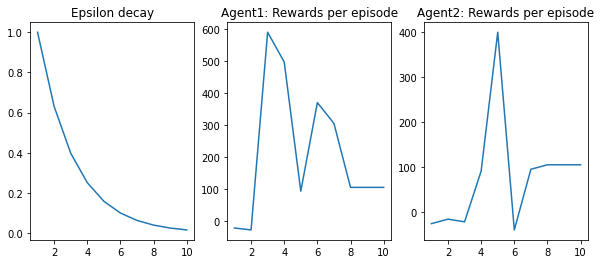

In [ ]:
q_learning()

Agent 1 route:  [13, 13, 13, 9, 13, 9, 5, 9, 5, 5, 6, 10, 14, 14, 10, 6, 2]
Agent 2 route:  [16, 16, 16, 12, 16, 12, 8, 12, 8, 8, 8, 7, 11, 15, 15, 11, 7]
Agent 1 route:  [13, 9, 5, 6, 2, 6, 2, 2, 2, 2, 6, 2, 6, 2, 2, 2, 2]
Agent 2 route:  [16, 12, 8, 7, 3, 7, 3, 3, 3, 3, 7, 3, 3, 3, 3, 7, 3]
Agent 1 route:  [13, 9, 5, 6, 2, 6, 2, 6, 2, 2, 2, 2, 6, 2, 6, 6, 5]
Agent 2 route:  [16, 12, 8, 7, 3, 7, 3, 7, 3, 3, 3, 3, 7, 3, 7, 8, 7]
Agent 1 route:  [13, 9, 5, 6, 2, 2, 2, 3, 7, 11, 15, 15, 11, 7, 3, 3, 4]
Agent 2 route:  [16, 12, 8, 7, 6, 10, 14, 14, 10, 6, 2, 6, 2, 2, 2, 1, 1]
Agent 1 route:  [13, 9, 5, 6, 2, 3, 4]
Agent 2 route:  [16, 12, 8, 7, 6, 2, 1]
Agent 1 route:  [13, 9, 5, 6, 2, 3, 4]
Agent 2 route:  [16, 12, 8, 7, 6, 2, 1]
Agent 1 route:  [13, 9, 5, 6, 2, 3, 4]
Agent 2 route:  [16, 12, 8, 7, 6, 2, 1]
Agent 1 route:  [13, 9, 5, 6, 2, 3, 4]
Agent 2 route:  [16, 12, 8, 7, 6, 2, 1]
Agent 1 route:  [13, 9, 5, 6, 2, 3, 4]
Agent 2 route:  [16, 12, 8, 7, 6, 2, 1]
Agent 1 route:  [13, 9, 5

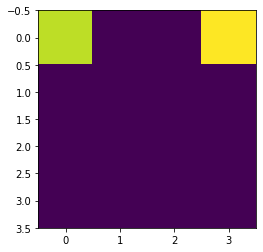

In [ ]:
q_learning(evaluation=True)

#2. MADPPG on Simple Adversary

##Networks

In [ ]:

class MultiAgentReplayBuffer:
    def __init__(self, max_size, critic_dims, actor_dims, 
            n_actions, n_agents, batch_size):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.n_agents = n_agents
        self.actor_dims = actor_dims
        self.batch_size = batch_size
        self.n_actions = n_actions

        self.state_memory = np.zeros((self.mem_size, critic_dims))
        self.new_state_memory = np.zeros((self.mem_size, critic_dims))
        self.reward_memory = np.zeros((self.mem_size, n_agents))
        self.terminal_memory = np.zeros((self.mem_size, n_agents), dtype=bool)

        self.init_actor_memory()

    def init_actor_memory(self):
        self.actor_state_memory = []
        self.actor_new_state_memory = []
        self.actor_action_memory = []

        for i in range(self.n_agents):
            self.actor_state_memory.append(
                            np.zeros((self.mem_size, self.actor_dims[i])))
            self.actor_new_state_memory.append(
                            np.zeros((self.mem_size, self.actor_dims[i])))
            self.actor_action_memory.append(
                            np.zeros((self.mem_size, self.n_actions)))


    def store_transition(self, raw_obs, state, action, reward, 
                               raw_obs_, state_, done):
        # this introduces a bug: if we fill up the memory capacity and then
        # zero out our actor memory, the critic will still have memories to access
        # while the actor will have nothing but zeros to sample. Obviously
        # not what we intend.
        # In reality, there's no problem with just using the same index
        # for both the actor and critic states. I'm not sure why I thought
        # this was necessary in the first place. Sorry for the confusion!

        #if self.mem_cntr % self.mem_size == 0 and self.mem_cntr > 0:
        #    self.init_actor_memory()
        
        index = self.mem_cntr % self.mem_size

        for agent_idx in range(self.n_agents):
            self.actor_state_memory[agent_idx][index] = raw_obs[agent_idx]
            self.actor_new_state_memory[agent_idx][index] = raw_obs_[agent_idx]
            self.actor_action_memory[agent_idx][index] = action[agent_idx]

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        states = self.state_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        actor_states = []
        actor_new_states = []
        actions = []
        for agent_idx in range(self.n_agents):
            actor_states.append(self.actor_state_memory[agent_idx][batch])
            actor_new_states.append(self.actor_new_state_memory[agent_idx][batch])
            actions.append(self.actor_action_memory[agent_idx][batch])

        return actor_states, states, actions, rewards, \
               actor_new_states, states_, terminal

    def ready(self):
        if self.mem_cntr >= self.batch_size:
            return True




In [ ]:

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, 
                    n_agents, n_actions, name, chkpt_dir):
        super(CriticNetwork, self).__init__()

        self.chkpt_file = os.path.join(chkpt_dir, name)

        self.fc1 = nn.Linear(input_dims+n_agents*n_actions, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
 
        self.to(self.device)

    def forward(self, state, action):
        x = F.relu(self.fc1(T.cat([state, action], dim=1)))
        x = F.relu(self.fc2(x))
        q = self.q(x)

        return q

    def save_checkpoint(self):
        T.save(self.state_dict(), self.chkpt_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.chkpt_file))


class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, 
                 n_actions, name, chkpt_dir):
        super(ActorNetwork, self).__init__()

        self.chkpt_file = os.path.join(chkpt_dir, name)

        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.pi = nn.Linear(fc2_dims, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
 
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        pi = T.softmax(self.pi(x), dim=1)

        return pi

    def save_checkpoint(self):
        T.save(self.state_dict(), self.chkpt_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.chkpt_file))

In [ ]:

class Agent:
    def __init__(self, actor_dims, critic_dims, n_actions, n_agents, agent_idx, chkpt_dir,
                    alpha=0.01, beta=0.01, fc1=64, 
                    fc2=64, gamma=0.95, tau=0.01):
        self.gamma = gamma
        self.tau = tau
        self.n_actions = n_actions
        self.agent_name = 'agent_%s' % agent_idx
        self.actor = ActorNetwork(alpha, actor_dims, fc1, fc2, n_actions, 
                                  chkpt_dir=chkpt_dir,  name=self.agent_name+'_actor')
        self.critic = CriticNetwork(beta, critic_dims, 
                            fc1, fc2, n_agents, n_actions, 
                            chkpt_dir=chkpt_dir, name=self.agent_name+'_critic')
        self.target_actor = ActorNetwork(alpha, actor_dims, fc1, fc2, n_actions,
                                        chkpt_dir=chkpt_dir, 
                                        name=self.agent_name+'_target_actor')
        self.target_critic = CriticNetwork(beta, critic_dims, 
                                            fc1, fc2, n_agents, n_actions,
                                            chkpt_dir=chkpt_dir,
                                            name=self.agent_name+'_target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        actions = self.actor.forward(state)
        noise = T.rand(self.n_actions).to(self.actor.device)
        action = actions + noise

        return action.detach().cpu().numpy()[0]

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        target_actor_params = self.target_actor.named_parameters()
        actor_params = self.actor.named_parameters()

        target_actor_state_dict = dict(target_actor_params)
        actor_state_dict = dict(actor_params)
        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                    (1-tau)*target_actor_state_dict[name].clone()

        self.target_actor.load_state_dict(actor_state_dict)

        target_critic_params = self.target_critic.named_parameters()
        critic_params = self.critic.named_parameters()

        target_critic_state_dict = dict(target_critic_params)
        critic_state_dict = dict(critic_params)
        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                    (1-tau)*target_critic_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

In [ ]:
class MADDPG:
    def __init__(self, actor_dims, critic_dims, n_agents, n_actions, 
                 scenario='simple',  alpha=0.01, beta=0.01, fc1=64, 
                 fc2=64, gamma=0.99, tau=0.01, chkpt_dir='tmp/maddpg/'):
        self.agents = []
        self.n_agents = n_agents
        self.n_actions = n_actions
        chkpt_dir += scenario 
        for agent_idx in range(self.n_agents):
            self.agents.append(Agent(actor_dims[agent_idx], critic_dims,  
                            n_actions, n_agents, agent_idx, alpha=alpha, beta=beta,
                            chkpt_dir=chkpt_dir))


    def save_checkpoint(self):
        print('... saving checkpoint ...')
        for agent in self.agents:
            agent.save_models()

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        for agent in self.agents:
            agent.load_models()

    def choose_action(self, raw_obs):
        actions = []
        for agent_idx, agent in enumerate(self.agents):
            action = agent.choose_action(raw_obs[agent_idx])
            actions.append(action)
        return actions

    def learn(self, memory):
        if not memory.ready():
            return

        actor_states, states, actions, rewards, \
        actor_new_states, states_, dones = memory.sample_buffer()

        device = self.agents[0].actor.device

        states = T.tensor(states, dtype=T.float).to(device)
        actions = T.tensor(actions, dtype=T.float).to(device)
        rewards = T.tensor(rewards, dtype=T.float).to(device)
        states_ = T.tensor(states_, dtype=T.float).to(device)
        dones = T.tensor(dones).to(device)

        all_agents_new_actions = []
        all_agents_new_mu_actions = []
        old_agents_actions = []

        for agent_idx, agent in enumerate(self.agents):
            new_states = T.tensor(actor_new_states[agent_idx], 
                                 dtype=T.float).to(device)

            new_pi = agent.target_actor.forward(new_states)

            all_agents_new_actions.append(new_pi)
            mu_states = T.tensor(actor_states[agent_idx], 
                                 dtype=T.float).to(device)
            pi = agent.actor.forward(mu_states)
            all_agents_new_mu_actions.append(pi)
            old_agents_actions.append(actions[agent_idx])

        new_actions = T.cat([acts for acts in all_agents_new_actions], dim=1)
        mu = T.cat([acts for acts in all_agents_new_mu_actions], dim=1)
        old_actions = T.cat([acts for acts in old_agents_actions],dim=1)

        for agent_idx, agent in enumerate(self.agents):
            critic_value_ = agent.target_critic.forward(states_, new_actions).flatten()
            critic_value_[dones[:,0]] = 0.0
            critic_value = agent.critic.forward(states, old_actions).flatten()

            target = rewards[:,agent_idx] + agent.gamma*critic_value_
            critic_loss = F.mse_loss(target, critic_value)
            agent.critic.optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            agent.critic.optimizer.step()

            actor_loss = agent.critic.forward(states, mu).flatten()
            actor_loss = -T.mean(actor_loss)
            agent.actor.optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            agent.actor.optimizer.step()

            agent.update_network_parameters()

##Main

In [ ]:
from make_env import make_env

def obs_list_to_state_vector(observation):
    state = np.array([])
    for obs in observation:
        state = np.concatenate([state, obs])
    return state

if __name__ == '__main__':
    #scenario = 'simple'
    scenario = 'simple_adversary'
    env = make_env(scenario)
    n_agents = env.n
    actor_dims = []

    print("Observatio space shape: ", env.observation_space)
    
    print("Action space: ", env.action_space)
    print("Action space shape: ", env.action_space[0].n)


    for i in range(n_agents):
        actor_dims.append(env.observation_space[i].shape[0])
        print("Observatio space shape: ", env.observation_space[i].shape[0])
    print("Actor dims: ", actor_dims)
    critic_dims = sum(actor_dims)

    # action space is a list of arrays, assume each agent has same action space
    n_actions = env.action_space[0].n
    maddpg_agents = MADDPG(actor_dims, critic_dims, n_agents, n_actions, 
                           fc1=64, fc2=64,  
                           alpha=0.01, beta=0.01, scenario=scenario,
                           chkpt_dir='tmp/maddpg/')

    memory = MultiAgentReplayBuffer(1000000, critic_dims, actor_dims, 
                        n_actions, n_agents, batch_size=1024)

    PRINT_INTERVAL = 1
    N_GAMES = 10000
    MAX_STEPS = 25
    total_steps = 0
    score_history = []
    evaluate = False
    best_score = 0

    if evaluate:
        maddpg_agents.load_checkpoint()

    for i in range(1, N_GAMES+1):
        obs = env.reset()
        score = 0
        done = [False]*n_agents
        episode_step = 0
        while not any(done):
            if evaluate:
                env.render()
                #time.sleep(0.1) # to slow down the action for the video
            # print("Obs: ", obs)
            actions = maddpg_agents.choose_action(obs)
            # print("Actions: ", actions)
            obs_, reward, done, info = env.step(actions)

            state = obs_list_to_state_vector(obs)
            state_ = obs_list_to_state_vector(obs_)

            if episode_step >= MAX_STEPS:
                done = [True]*n_agents

            memory.store_transition(obs, state, actions, reward, obs_, state_, done)

            if total_steps % 100 == 0 and not evaluate:
                maddpg_agents.learn(memory)

            obs = obs_

            score += sum(reward)
            total_steps += 1
            episode_step += 1

        score_history.append(score)
        avg_score = np.mean(score_history[-100:])
        if not evaluate:
            if avg_score > best_score:
                # maddpg_agents.save_checkpoint()
                best_score = avg_score
        if i % 50 == 0 and i > 0:
            print('episode', i, 'average score {:.1f}'.format(avg_score))

Observatio space shape:  [Box(8,), Box(10,), Box(10,)]
Action space:  [Discrete(5), Discrete(5), Discrete(5)]
Action space shape:  5
Observatio space shape:  8
Observatio space shape:  10
Observatio space shape:  10
Actor dims:  [8, 10, 10]
episode 50 average score -20.9
episode 100 average score -45.7
episode 150 average score -61.5
episode 200 average score -44.7
episode 250 average score -33.2
episode 300 average score -33.2
episode 350 average score -34.5
episode 400 average score -31.9
episode 450 average score -35.3
episode 500 average score -32.6
episode 550 average score -29.9
episode 600 average score -31.7
episode 650 average score -30.3
episode 700 average score -29.5
episode 750 average score -29.3
episode 800 average score -31.0
episode 850 average score -31.3
episode 900 average score -35.0
episode 950 average score -36.7
episode 1000 average score -37.7
episode 1050 average score -37.5
episode 1100 average score -31.5
episode 1150 average score -31.2
episode 1200 average

Text(0.5, 1.0, 'MADDPG on Simple Adversary')

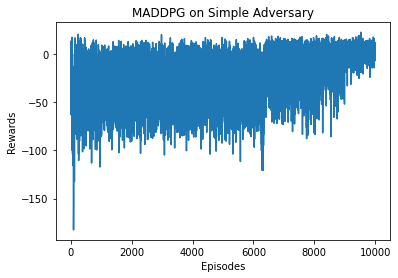

In [ ]:
np.shape(score_history)
x = [e for e in range(10000)]
yr = score_history
plt.plot(x,yr)
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.title('MADDPG on Simple Adversary')

#2. Multiagent Grid world

In [ ]:
class MAalgo_MAGridWorld(gym.Env):
    
    metadata = { 'render.modes' : ['human', 'rgb_array'] }
        
    def __init__(self, size, n_agents):
        self.size = size
        self._grid_size = (self.size, self.size)
        self.world = np.zeros((self._grid_size))
        self._timestep = None
        self._max_timestep = int(self.size*4)
        self.n_agents = n_agents
        self.dist = int((self.size-1)/(n_agents-1))
        self._step_cost = -0.1
        self.observation_space = spaces.Box(low=0, high=self.size, shape=(self.size, self.size))
        self.action_space = spaces.Discrete(5)

    def reset(self):
        self.agent_pos = []
        self.goal_pos = []
        self._timestep = 0
        self.done = [False for i in range(self.n_agents)]
        for i in range(self.n_agents):
            self.agent_pos.append([self.size-1, i*self.dist])
            self.goal_pos.append([0, i*self.dist])
        self.goal_pos.reverse()
        observation = self.agent_pos
        return observation


    def _compute_distance(self, x, y):
        dist = np.abs(x[0]-y[0]) + np.abs(x[1]-y[1])
        return dist


    def _is_inside_grid(self, pos):
        return (0 <= pos[0] < self._grid_size[0]) and (0 <= pos[1] < self._grid_size[1])


    def _is_collision(self, new_pos, agent):
        for i in range(self.n_agents):
            if i == agent:
                continue
            elif new_pos == self.agent_pos[i]:
                return True
            elif new_pos == self.goal_pos[i]:
                return True

    def step(self, actions):

        self._timestep += 1
        old_pos = self.agent_pos.copy()
        rewards = [0 for _ in range(self.n_agents)]

        for i in range(self.n_agents):
            self.update_agent_pos(i, actions[i])
            old_dist = self._compute_distance(old_pos[i], self.goal_pos[i])
            new_dist = self._compute_distance(self.agent_pos[i], self.goal_pos[i])
            
            if new_dist < old_dist:
              rewards[i] = 5 #-1 worked
            elif new_dist > old_dist:
              rewards[i] = -2 #-2 worked

            elif (new_dist == old_dist) and not self.done[i]:
              rewards[i] = -2 #-2 worked

            if new_dist < 1.5:
              rewards[i] += 25
            
            if (self.agent_pos[i] == self.goal_pos[i]):
              self.done[i] = True
              rewards[i] += 250
            else:
              self.done[i] = False
              rewards[i] += -5

        if self._timestep >= self._max_timestep:
          self.done = [True for i in range(self.n_agents)]
            
        observation = self.agent_pos
        info = {}
        return observation, rewards, self.done, info #all(done)



    def update_agent_pos(self, agent, action):
        next_pos = copy(self.agent_pos[agent])
        if action == 0: # Down
            next_pos[0] += 1
        elif action == 1: # Up
            next_pos[0] -= 1
        elif action == 2: # Right
            next_pos[1] += 1
        elif action == 3: # Left
            next_pos[1] -= 1
        elif action == 4: # No move
            pass
        else:
            raise Exception('Action is not valid')
            
        if self._is_inside_grid(next_pos) and not self._is_collision(next_pos, agent):
            self.agent_pos[agent] = next_pos
        else:
            pass
        

    def render(self):
        state = np.copy(self.world)
        for i in range(self.n_agents):
            state[tuple(self.agent_pos[i])] = 1 - (0.1 * i)
            state[tuple(self.goal_pos[i])] = 1 - (0.1 * i)
        return plt.imshow(state)

In [ ]:
class RandomAgent:
    
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def step(self, observation):
        return np.random.choice(self.action_space.n)

#3. MADDPG on Grid world

##Networks: GW

In [ ]:

class MultiAgentReplayBuffer:
    def __init__(self, max_size, critic_dims, actor_dims, 
            n_actions, n_agents, batch_size):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.n_agents = n_agents
        self.actor_dims = actor_dims
        self.batch_size = batch_size
        self.n_actions = n_actions

        self.state_memory = np.zeros((self.mem_size, critic_dims))
        self.new_state_memory = np.zeros((self.mem_size, critic_dims))
        self.reward_memory = np.zeros((self.mem_size, n_agents))
        self.terminal_memory = np.zeros((self.mem_size, n_agents), dtype=bool)

        self.init_actor_memory()

    def init_actor_memory(self):
        self.actor_state_memory = []
        self.actor_new_state_memory = []
        self.actor_action_memory = []

        for i in range(self.n_agents):
            self.actor_state_memory.append(
                            np.zeros((self.mem_size, self.actor_dims[i])))
            self.actor_new_state_memory.append(
                            np.zeros((self.mem_size, self.actor_dims[i])))
            self.actor_action_memory.append(
                            np.zeros((self.mem_size, self.n_actions)))


    def store_transition(self, raw_obs, state, action, reward, 
                               raw_obs_, state_, done):
        # this introduces a bug: if we fill up the memory capacity and then
        # zero out our actor memory, the critic will still have memories to access
        # while the actor will have nothing but zeros to sample. Obviously
        # not what we intend.
        # In reality, there's no problem with just using the same index
        # for both the actor and critic states. I'm not sure why I thought
        # this was necessary in the first place. Sorry for the confusion!

        #if self.mem_cntr % self.mem_size == 0 and self.mem_cntr > 0:
        #    self.init_actor_memory()
        
        index = self.mem_cntr % self.mem_size

        for agent_idx in range(self.n_agents):
            self.actor_state_memory[agent_idx][index] = raw_obs[agent_idx]
            self.actor_new_state_memory[agent_idx][index] = raw_obs_[agent_idx]
            self.actor_action_memory[agent_idx][index] = action[agent_idx]

        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        states = self.state_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        actor_states = []
        actor_new_states = []
        actions = []
        for agent_idx in range(self.n_agents):
            actor_states.append(self.actor_state_memory[agent_idx][batch])
            actor_new_states.append(self.actor_new_state_memory[agent_idx][batch])
            actions.append(self.actor_action_memory[agent_idx][batch])

        return actor_states, states, actions, rewards, \
               actor_new_states, states_, terminal

    def ready(self):
        if self.mem_cntr >= self.batch_size:
            return True




In [ ]:

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, 
                    n_agents, n_actions, name, chkpt_dir):
        super(CriticNetwork, self).__init__()

        self.chkpt_file = os.path.join(chkpt_dir, name)

        self.fc1 = nn.Linear(input_dims+n_agents*n_actions, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.q = nn.Linear(fc2_dims, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=beta)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
 
        self.to(self.device)

    def forward(self, state, action):
        x = F.relu(self.fc1(T.cat([state, action], dim=1)))
        x = F.relu(self.fc2(x))
        q = self.q(x)

        return q

    # def save_checkpoint(self):
    #     T.save(self.state_dict(), self.chkpt_file)

    # def load_checkpoint(self):
    #     self.load_state_dict(T.load(self.chkpt_file))


class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, 
                 n_actions, name, chkpt_dir):
        super(ActorNetwork, self).__init__()

        self.chkpt_file = os.path.join(chkpt_dir, name)

        self.fc1 = nn.Linear(input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.pi = nn.Linear(fc2_dims, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
 
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state), inplace=False)
        x = F.relu(self.fc2(x), inplace = False)
        pi = T.softmax(self.pi(x), dim=1)

        # print(pi)

        return pi

    # def save_checkpoint(self):
    #     T.save(self.state_dict(), self.chkpt_file)

    # def load_checkpoint(self):
    #     self.load_state_dict(T.load(self.chkpt_file))

In [ ]:

class Agent:
    def __init__(self, actor_dims, critic_dims, n_actions, n_agents, agent_idx, chkpt_dir,
                    alpha=0.01, beta=0.01, fc1=64, 
                    fc2=64, gamma=0.95, tau=0.01):
        self.gamma = gamma
        self.tau = tau
        self.n_actions = n_actions
        self.agent_name = 'agent_%s' % agent_idx
        self.actor = ActorNetwork(alpha, actor_dims, fc1, fc2, n_actions, 
                                  chkpt_dir=chkpt_dir,  name=self.agent_name+'_actor')
        self.critic = CriticNetwork(beta, critic_dims, 
                            fc1, fc2, n_agents, n_actions, 
                            chkpt_dir=chkpt_dir, name=self.agent_name+'_critic')
        self.target_actor = ActorNetwork(alpha, actor_dims, fc1, fc2, n_actions,
                                        chkpt_dir=chkpt_dir, 
                                        name=self.agent_name+'_target_actor')
        self.target_critic = CriticNetwork(beta, critic_dims, 
                                            fc1, fc2, n_agents, n_actions,
                                            chkpt_dir=chkpt_dir,
                                            name=self.agent_name+'_target_critic')

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        actions = self.actor.forward(state).clone()
        noise = T.rand(self.n_actions).to(self.actor.device)
        action = actions + noise

        return action.detach().cpu().numpy()[0]

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        target_actor_params = self.target_actor.named_parameters()
        actor_params = self.actor.named_parameters()

        target_actor_state_dict = dict(target_actor_params)
        actor_state_dict = dict(actor_params)
        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                    (1-tau)*target_actor_state_dict[name].clone()

        self.target_actor.load_state_dict(actor_state_dict)

        target_critic_params = self.target_critic.named_parameters()
        critic_params = self.critic.named_parameters()

        target_critic_state_dict = dict(target_critic_params)
        critic_state_dict = dict(critic_params)
        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                    (1-tau)*target_critic_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)

    # def save_models(self):
    #     self.actor.save_checkpoint()
    #     self.target_actor.save_checkpoint()
    #     self.critic.save_checkpoint()
    #     self.target_critic.save_checkpoint()

    # def load_models(self):
    #     self.actor.load_checkpoint()
    #     self.target_actor.load_checkpoint()
    #     self.critic.load_checkpoint()
    #     self.target_critic.load_checkpoint()

In [ ]:
class Grid_MADDPG:
    def __init__(self, actor_dims, critic_dims, n_agents, n_actions, 
                 scenario='simple',  alpha=0.01, beta=0.01, fc1=64, 
                 fc2=64, gamma=0.99, tau=0.01, chkpt_dir='tmp/maddpg/'):
        self.agents = []
        self.n_agents = n_agents
        self.n_actions = n_actions
        chkpt_dir += scenario 
        for agent_idx in range(self.n_agents):
            self.agents.append(Agent(actor_dims[agent_idx], critic_dims,  
                            n_actions, n_agents, agent_idx, alpha=alpha, beta=beta,
                            chkpt_dir=chkpt_dir))


    # def save_checkpoint(self):
    #     print('... saving checkpoint ...')
    #     for agent in self.agents:
    #         agent.save_models()

    # def load_checkpoint(self):
    #     print('... loading checkpoint ...')
    #     for agent in self.agents:
    #         agent.load_models()

    def choose_action(self, raw_obs):
        actions = []
        for agent_idx, agent in enumerate(self.agents):
            action = agent.choose_action(raw_obs[agent_idx])
            actions.append(action)
        return actions

    def learn(self, memory):
        if not memory.ready():
            return
        torch.autograd.set_detect_anomaly(True)
        actor_states, states, actions, rewards, \
        actor_new_states, states_, dones = memory.sample_buffer()

        device = self.agents[0].actor.device

        states = T.tensor(states, dtype=T.float).to(device)
        actions = T.tensor(actions, dtype=T.float).to(device)
        rewards = T.tensor(rewards, dtype=T.float).to(device)
        states_ = T.tensor(states_, dtype=T.float).to(device)
        dones = T.tensor(dones).to(device)

        all_agents_new_actions = []
        all_agents_new_mu_actions = []
        old_agents_actions = []

        for agent_idx, agent in enumerate(self.agents):
            new_states = T.tensor(actor_new_states[agent_idx], 
                                 dtype=T.float).to(device)

            new_pi = agent.target_actor.forward(new_states)

            all_agents_new_actions.append(new_pi)
            mu_states = T.tensor(actor_states[agent_idx], 
                                 dtype=T.float).to(device)
            pi = agent.actor.forward(mu_states)
            all_agents_new_mu_actions.append(pi)
            old_agents_actions.append(actions[agent_idx])

        new_actions = T.cat([acts for acts in all_agents_new_actions], dim=1)
        mu = T.cat([acts for acts in all_agents_new_mu_actions], dim=1)
        old_actions = T.cat([acts for acts in old_agents_actions],dim=1)
        
        
        for agent_idx, agent in enumerate(self.agents):
            critic_value_ = agent.target_critic.forward(states_, new_actions).flatten()
            critic_value_[dones[:,0]] = 0.0
            critic_value = agent.critic.forward(states, old_actions).flatten()

            target = rewards[:,agent_idx] + agent.gamma*critic_value_
            critic_loss = F.mse_loss(target, critic_value)
            agent.critic.optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            agent.critic.optimizer.step()

            

            actor_loss = agent.critic.forward(states, mu).flatten()
            actor_loss = -T.mean(actor_loss)

            agent.actor.optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            agent.actor.optimizer.step()

            agent.update_network_parameters()

##Grid main

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation:  Box(4, 4)
Actions:  Discrete(5)
Episode: 10, Individual Rewards: [-120, -100]
Episode: 20, Individual Rewards: [-120, -120]
Episode: 30, Individual Rewards: [-120, -120]
Episode: 40, Individual Rewards: [-120, -120]
Episode: 50, Individual Rewards: [-120, -120]
Episode: 60, Individual Rewards: [-120, -120]
Episode: 70, Individual Rewards: [-120, -120]
Episode: 80, Individual Rewards: [-120, -120]
Episode: 90, Individual Rewards: [-120, -120]
Agent1 Route:  [[3, 0], [2, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]
Agent2 Route:  [[3, 3], [2, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3]]


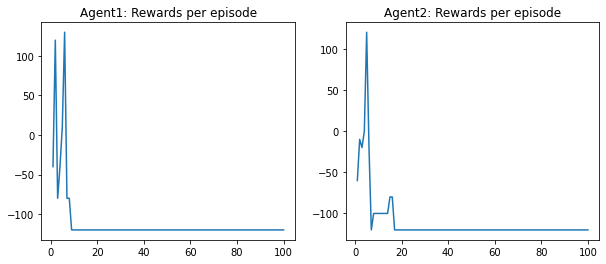

In [ ]:
from tensorflow.keras.utils import to_categorical
def obs_list_to_state_vector(observation):
    state = np.array([])
    for obs in observation:
        state = np.concatenate([state, obs])
    return state

states_map = {(0,0): 0, (0,1): 1, (0,2): 2, (0,3): 3,
                  (1,0): 4, (1,1): 5, (1,2): 6, (1,3): 7,
                  (2,0): 8, (2,1): 9, (2,2): 10, (2,3): 11,
                  (3,0): 12, (3,1): 13, (3,2): 14, (3,3): 15}


env = MAalgo_MAGridWorld(4, 2)
obs = env.reset()
print("Observation: ", env.observation_space)
print("Actions: ", env.action_space)


n_agents = 2
actor_dims = []
for i in range(n_agents):
  actor_dims.append(16)
critic_dims = sum(actor_dims)

# action space is a list of arrays, assume each agent has same action space
n_actions = 5
maddpg_agents = Grid_MADDPG(actor_dims, critic_dims, n_agents, n_actions, 
                      fc1=64, fc2=64,  
                      alpha=0.01, beta=0.01,
                      chkpt_dir='tmp/maddpg_grid/')

memory = MultiAgentReplayBuffer(10000, critic_dims, actor_dims, 
                  n_actions, n_agents, batch_size=64)

total_episodes = 100
epsilon = 1
epsilon_decay = (0.001/1)**(1/total_episodes)
rewards_val = []
agent1_route = [[3,0]]
agent2_route = [[3,3]]

for episode in range(total_episodes):
  obs = env.reset()
  obs_new = []
  total_steps = 0
  for state in obs:
    state = states_map[tuple(state)]
    one_hot = to_categorical(state, 16)
    obs_new.append(one_hot)
  obs = obs_new
  done = [False]*n_agents
  total_rewards = [0, 0]

  while not any(done) and total_steps < 20:
      
      #time.sleep(0.1) # to slow down the action for the video
      # print("Grid w obs: ", obs)
      
      actions = maddpg_agents.choose_action(obs)
      # print("action prob: ", actions)
      actions_new = []

      for action in actions:
        rand_num = np.random.random()
        if epsilon > rand_num:
          # actions_new.append(np.random.choice(5))
          actions_new.append(np.argmax(action))
        else:
          actions_new.append(np.argmax(action))

        # actions_new.append(np.random.choice(5,1,p = action)[0])

      # print("Actions_new", actions_new)

      obs_, reward, done, info = env.step(actions_new)

      if episode == total_episodes - 1:
        agent1_route.append(obs_[0])
        agent2_route.append(obs_[1])
        # print("Actions: ", actions)
      
      obs_new_ = []
      for state in obs_:
        state = states_map[tuple(state)]
        one_hot = to_categorical(state, 16)
        obs_new_.append(one_hot)
      obs_ = obs_new_

      state = obs_list_to_state_vector(obs)
      state_ = obs_list_to_state_vector(obs_)

      # if total_steps >= MAX_STEPS:
      #     done = [True]*n_agents


      memory.store_transition(obs, state, actions, reward, obs_, state_, done)

      if total_steps % 2 == 0:
        maddpg_agents.learn(memory)

      obs = obs_
      total_steps += 1

      for agent in range(2):
        total_rewards[agent] += reward[agent]

  
  if epsilon > 0.001:
    epsilon *= epsilon_decay
  else:
    epsilon = 0.001
      
  rewards_val.append(total_rewards)
    
  #After every episode
  # avg_reward = np.mean(rewards_val[-10:])
  
  if episode % (total_episodes // 10) == 0 and episode > 0:
      print('Episode: {}, Individual Rewards: {}'.format(episode, total_rewards))
      


x = [episode for episode in range(1, total_episodes+1)]
yr1 = [rewards_val[episode][0] for episode in range(total_episodes)]
yr2 = [rewards_val[episode][1] for episode in range(total_episodes)]

#Plots showing episodes vs epsilon, episodes vs rewards
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

#episodes vs rewards
ax1.plot(x,yr1)
ax1.set_title("Agent1: Rewards per episode")

#episodes vs rewards
ax2.plot(x,yr2)
ax2.set_title("Agent2: Rewards per episode")

print("Agent1 Route: ", agent1_route)
print("Agent2 Route: ", agent2_route)

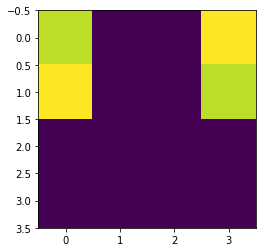

In [ ]:
env.render()

#Improved MADDPG

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Observation:  Box(4, 4)
Actions:  Discrete(5)
Episode: 100, Individual Rewards: [-77, -77]
Episode: 200, Individual Rewards: [133, 327]
Episode: 300, Individual Rewards: [-70, 270]
Episode: 400, Individual Rewards: [-21, 305]
Episode: 500, Individual Rewards: [298, 298]
Episode: 600, Individual Rewards: [305, 305]
Episode: 700, Individual Rewards: [298, 298]
Episode: 800, Individual Rewards: [305, 18]
Episode: 900, Individual Rewards: [305, 305]
Agent1 Route:  [[3, 0], [2, 0], [2, 1], [1, 1], [0, 1], [0, 2], [0, 3]]
Agent2 Route:  [[3, 3], [3, 2], [3, 1], [2, 1], [1, 1], [0, 1], [0, 0]]


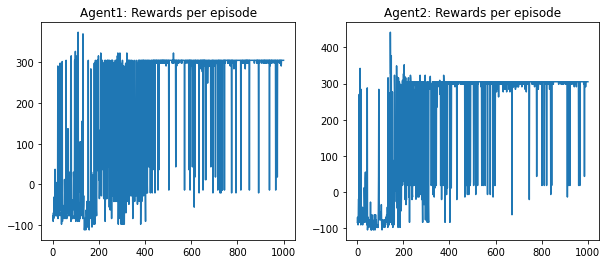

In [ ]:
from tensorflow.keras.utils import to_categorical
def obs_list_to_state_vector(observation):
    state = np.array([])
    for obs in observation:
        state = np.concatenate([state, obs])
    return state

states_map = {(0,0): 0, (0,1): 1, (0,2): 2, (0,3): 3,
                  (1,0): 4, (1,1): 5, (1,2): 6, (1,3): 7,
                  (2,0): 8, (2,1): 9, (2,2): 10, (2,3): 11,
                  (3,0): 12, (3,1): 13, (3,2): 14, (3,3): 15}


env = MAalgo_MAGridWorld(4, 2)
obs = env.reset()
print("Observation: ", env.observation_space)
print("Actions: ", env.action_space)


n_agents = 2
actor_dims = []
for i in range(n_agents):
  actor_dims.append(16)
critic_dims = sum(actor_dims)

# action space is a list of arrays, assume each agent has same action space
n_actions = 5
maddpg_agents = Grid_MADDPG(actor_dims, critic_dims, n_agents, n_actions, 
                      fc1=64, fc2=64,  
                      alpha=0.001, beta=0.001, gamma = 0.99,
                      chkpt_dir='tmp/maddpg_grid/')

memory = MultiAgentReplayBuffer(10000, critic_dims, actor_dims, 
                  n_actions, n_agents, batch_size=128)

total_episodes = 1000
epsilon = 1
epsilon_decay = (0.001/1)**(1/total_episodes)
rewards_val = []
agent1_route = [[3,0]]
agent2_route = [[3,3]]

for episode in range(total_episodes):
  obs = env.reset()
  obs_new = []
  total_steps = 0
  for state in obs:
    state = states_map[tuple(state)]
    one_hot = to_categorical(state, 16)
    obs_new.append(one_hot)
  obs = obs_new
  done = [False]*n_agents
  total_rewards = [0, 0]

  while not any(done) and total_steps < 20:
      
      #time.sleep(0.1) # to slow down the action for the video
      # print("Grid w obs: ", obs)
      
      actions = maddpg_agents.choose_action(obs)
      # print("action prob: ", actions)
      actions_new = []

      for action in actions:
        rand_num = np.random.random()
        if epsilon > rand_num:
          actions_new.append(np.random.choice(5))
          # print(actions_new)
        else:
          actions_new.append(np.argmax(action))

        # actions_new.append(np.random.choice(5,1,p = action)[0])

      # print("Actions_new", actions_new)

      obs_, reward, done, info = env.step(actions_new)

      if episode == total_episodes - 1:
        agent1_route.append(obs_[0])
        agent2_route.append(obs_[1])
        # print("Actions: ", actions)
      
      obs_new_ = []
      for state in obs_:
        state = states_map[tuple(state)]
        one_hot = to_categorical(state, 16)
        obs_new_.append(one_hot)
      obs_ = obs_new_

      state = obs_list_to_state_vector(obs)
      state_ = obs_list_to_state_vector(obs_)

      # if total_steps >= MAX_STEPS:
      #     done = [True]*n_agents

      # print(reward)

      # if reward[0] > 10:
      #   reward[0] += 50


      memory.store_transition(obs, state, actions, reward, obs_, state_, done)

      if total_steps % 2 == 0:
        maddpg_agents.learn(memory)

      obs = obs_
      total_steps += 1

      for agent in range(2):
        total_rewards[agent] += reward[agent]

  
  if epsilon > 0.01:
    epsilon *= epsilon_decay
  else:
    epsilon = 0.01
      
  rewards_val.append(total_rewards)
    
  #After every episode
  # avg_reward = np.mean(rewards_val[-10:])
  
  if episode % (total_episodes // 10) == 0 and episode > 0:
      print('Episode: {}, Individual Rewards: {}'.format(episode, total_rewards))
      


x = [episode for episode in range(1, total_episodes+1)]
yr1 = [rewards_val[episode][0] for episode in range(total_episodes)]
yr2 = [rewards_val[episode][1] for episode in range(total_episodes)]

#Plots showing episodes vs epsilon, episodes vs rewards
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

#episodes vs rewards
ax1.plot(x,yr1)
ax1.set_title("Agent1: Rewards per episode")

#episodes vs rewards
ax2.plot(x,yr2)
ax2.set_title("Agent2: Rewards per episode")

print("Agent1 Route: ", agent1_route)
print("Agent2 Route: ", agent2_route)

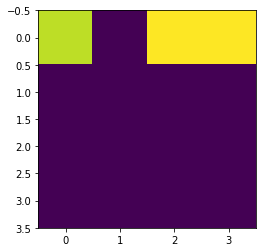

In [ ]:
env.render()